In [1]:
import requests, json
import pandas as pd
import numpy as np
import os
import glob
import gzip 
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import nltk
import ssl
from transformers import pipeline
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
from pandas_datareader import data
import yfinance as yf
import datetime
from transformers import pipeline
from IPython.display import clear_output
from statsmodels.api import OLS
import statsmodels.api as sm


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Import COVID headlines

In [2]:
df = pd.read_csv('/Users/marnixtimmermans/Desktop/Thesis1/Data/Sentiment Analysis/Headline_Korea.csv')

# Cleaning dates & text, POS tagging and Lemmatizing

In [3]:
#Cleaning dates 

for i, row in df.iterrows():
    if row['Date'].startswith("Published :"):
        row['Date'] = row['Date'][11:]
        print(row['Date'])
    elif row['Date'].startswith("Posted :"):
        row['Date'] = row['Date'][9:]
        print(row['Date'])
    else:
        print(row['Date'])


df['Date'] = df["Date"].str.split(r"\bUpdated\b", expand=True)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date') 

df


 Apr 5, 2020 - 17:57        Updated : Apr 5, 2020 - 17:57
 Apr 5, 2020 - 17:34        Updated : Apr 5, 2020 - 17:34
 Apr 5, 2020 - 17:01        Updated : Apr 5, 2020 - 17:05
 Apr 5, 2020 - 16:56        Updated : Apr 5, 2020 - 16:56
 Apr 5, 2020 - 16:50        Updated : Apr 5, 2020 - 16:56
 Apr 5, 2020 - 16:19        Updated : Apr 6, 2020 - 09:48
 Apr 5, 2020 - 16:19        Updated : Apr 5, 2020 - 18:02
 Apr 5, 2020 - 15:05        Updated : Apr 7, 2020 - 02:47
 Apr 5, 2020 - 14:54        Updated : Apr 5, 2020 - 14:54
 Apr 5, 2020 - 14:20        Updated : Apr 5, 2020 - 14:20
 Apr 5, 2020 - 13:56        Updated : Apr 5, 2020 - 13:56
 Apr 5, 2020 - 12:12        Updated : Apr 5, 2020 - 12:16
 Apr 5, 2020 - 11:56        Updated : Apr 5, 2020 - 14:32
 Apr 5, 2020 - 11:30        Updated : Apr 5, 2020 - 11:30
 Apr 5, 2020 - 10:30        Updated : Apr 5, 2020 - 16:54
 Apr 4, 2020 - 15:37        Updated : Apr 4, 2020 - 15:37
 Apr 4, 2020 - 15:20        Updated : Apr 4, 2020 - 15:20
 Apr 4, 2020 -

 Sept 8, 2020 - 16:18        Updated : Sept 8, 2020 - 16:21
 Sept 8, 2020 - 16:10        Updated : Sept 8, 2020 - 16:10
 Sept 8, 2020 - 16:05        Updated : Sept 8, 2020 - 16:05
 Sept 8, 2020 - 15:48        Updated : Sept 8, 2020 - 15:48
 Sept 8, 2020 - 15:47        Updated : Sept 8, 2020 - 19:12
 Sept 8, 2020 - 15:29        Updated : Sept 8, 2020 - 15:30
 Sept 8, 2020 - 15:25        Updated : Sept 8, 2020 - 15:37
 Sept 8, 2020 - 15:23        Updated : Sept 8, 2020 - 15:24
 Sept 8, 2020 - 14:56        Updated : Sept 8, 2020 - 15:18
 Sept 8, 2020 - 14:36        Updated : Sept 8, 2020 - 14:41
 Sept 8, 2020 - 14:25        Updated : Sept 8, 2020 - 14:25
 Sept 8, 2020 - 14:11        Updated : Sept 8, 2020 - 17:00
 Sept 8, 2020 - 12:51        Updated : Sept 8, 2020 - 13:03
 Sept 8, 2020 - 12:47        Updated : Sept 8, 2020 - 12:47
 Sept 8, 2020 - 12:30        Updated : Sept 8, 2020 - 20:51
 Sept 8, 2020 - 10:54        Updated : Sept 8, 2020 - 11:09
 Sept 8, 2020 - 10:46        Updated : S

 Jun 4, 2020 - 17:55        Updated : Jun 4, 2020 - 17:58
 Jun 4, 2020 - 17:48        Updated : Jun 4, 2020 - 17:48
 Jun 4, 2020 - 16:43        Updated : Jun 4, 2020 - 18:10
 Jun 4, 2020 - 16:36        Updated : Jun 4, 2020 - 16:59
 Jun 4, 2020 - 16:21        Updated : Jun 4, 2020 - 16:21
 Jun 4, 2020 - 16:19        Updated : Jun 4, 2020 - 16:23
 Jun 4, 2020 - 15:54        Updated : Jun 4, 2020 - 15:58
 Jun 4, 2020 - 15:52        Updated : Jun 4, 2020 - 15:52
 Jun 4, 2020 - 15:35        Updated : Jun 4, 2020 - 16:02
 Jun 4, 2020 - 14:42        Updated : Jun 4, 2020 - 14:42
 Jun 4, 2020 - 13:49        Updated : Jun 4, 2020 - 16:22
 Jun 4, 2020 - 13:39        Updated : Jun 4, 2020 - 13:39
 Jun 4, 2020 - 10:24        Updated : Jun 4, 2020 - 16:36
 Jun 4, 2020 - 10:09        Updated : Jun 4, 2020 - 10:09
 Jun 4, 2020 - 10:01        Updated : Jun 4, 2020 - 10:01
 Jun 4, 2020 - 09:28        Updated : Jun 4, 2020 - 09:28
 Jun 4, 2020 - 09:21        Updated : Jun 4, 2020 - 15:19
 Jun 4, 2020 -

 Apr 24, 2020 - 13:18        Updated : Apr 24, 2020 - 13:18
 Apr 24, 2020 - 12:04        Updated : Apr 24, 2020 - 12:04
 Apr 24, 2020 - 10:52        Updated : Apr 24, 2020 - 10:52
 Apr 24, 2020 - 09:31        Updated : Apr 24, 2020 - 10:00
 Apr 24, 2020 - 08:34        Updated : Apr 24, 2020 - 08:51
 Apr 23, 2020 - 18:05        Updated : Apr 23, 2020 - 18:16
 Apr 23, 2020 - 17:55        Updated : Apr 23, 2020 - 17:55
 Apr 23, 2020 - 17:53        Updated : Apr 23, 2020 - 17:57
 Apr 23, 2020 - 17:44        Updated : Apr 23, 2020 - 17:44
 Apr 23, 2020 - 17:15        Updated : Apr 23, 2020 - 17:59
 Apr 23, 2020 - 17:13        Updated : Apr 23, 2020 - 17:16
 Apr 23, 2020 - 17:01        Updated : Apr 24, 2020 - 09:11
 Apr 23, 2020 - 16:45        Updated : Apr 23, 2020 - 16:54
 Apr 23, 2020 - 16:30        Updated : Apr 24, 2020 - 02:47
 Apr 23, 2020 - 16:26        Updated : Apr 23, 2020 - 16:26
 Apr 23, 2020 - 16:19        Updated : Apr 23, 2020 - 16:25
 Apr 23, 2020 - 16:12        Updated : A

2020-06-22 14:31
2020-06-22 14:23
2020-06-22 10:21
2020-06-22 09:26
2020-06-21 19:36
2020-06-21 19:33
2020-06-21 17:37
2020-06-21 17:26
2020-06-21 17:10
2020-06-21 17:10
2020-06-21 17:04
2020-06-21 17:01
2020-06-21 17:00
2020-06-21 16:59
2020-06-21 16:54
2020-06-21 16:37
2020-06-21 15:39
2020-06-21 15:39
2020-06-21 15:20
2020-06-21 15:00
2020-06-21 13:03
2020-06-21 10:24
2020-06-20 11:06
2020-06-20 10:54
2020-06-19 18:32
2020-06-19 17:23
2020-06-19 17:06
2020-06-19 17:06
2020-06-19 17:06
2020-06-19 17:03
2020-06-19 16:53
2020-06-19 13:48
2020-06-19 10:55
2020-06-19 10:06
2020-06-19 09:09
2020-06-18 18:11
2020-06-18 17:56
2020-06-18 17:51
2020-06-18 17:43
2020-06-18 17:16
2020-06-18 17:15
2020-06-18 17:07
2020-06-18 16:13
2020-06-18 16:10
2020-06-18 14:52
2020-06-18 14:34
2020-06-18 09:35
2020-06-17 18:15
2020-06-17 17:59
2020-06-17 17:33
2020-06-17 17:28
2020-06-17 17:13
2020-06-17 17:12
2020-06-17 17:09
2020-06-17 17:09
2020-06-17 17:08
2020-06-17 17:06
2020-06-17 17:04
2020-06-17 17:

 May 26, 2020 - 18:20        Updated : May 27, 2020 - 09:15
 May 26, 2020 - 17:09        Updated : May 26, 2020 - 18:28
 May 26, 2020 - 16:57        Updated : May 26, 2020 - 16:57
 May 26, 2020 - 16:43        Updated : May 26, 2020 - 16:43
 May 26, 2020 - 16:37        Updated : May 26, 2020 - 16:42
 May 26, 2020 - 16:31        Updated : May 26, 2020 - 16:34
 May 26, 2020 - 15:23        Updated : May 26, 2020 - 17:48
 May 26, 2020 - 15:09        Updated : May 26, 2020 - 15:09
 May 26, 2020 - 15:06        Updated : May 26, 2020 - 15:09
 May 26, 2020 - 15:00        Updated : May 26, 2020 - 15:00
 May 26, 2020 - 14:47        Updated : May 26, 2020 - 14:50
 May 26, 2020 - 13:48        Updated : May 26, 2020 - 13:51
 May 26, 2020 - 13:00        Updated : May 26, 2020 - 13:00
 May 26, 2020 - 11:26        Updated : May 26, 2020 - 11:26
 May 26, 2020 - 11:15        Updated : May 26, 2020 - 15:41
 May 26, 2020 - 11:13        Updated : May 26, 2020 - 11:13
 May 26, 2020 - 11:09        Updated : M

2020-08-26 09:22
2020-08-26 09:11
2020-08-26 09:07
2020-08-25 20:45
2020-08-25 19:16
2020-08-25 18:09
2020-08-25 17:56
2020-08-25 17:55
2020-08-25 17:53
2020-08-25 17:28
2020-08-25 17:02
2020-08-25 17:01
2020-08-25 16:52
2020-08-25 16:28
2020-08-25 16:16
2020-08-25 16:00
2020-08-25 15:40
2020-08-25 15:02
2020-08-25 14:05
2020-08-25 13:53
2020-08-25 13:26
2020-08-25 13:01
2020-08-25 10:49
2020-08-25 09:26
2020-08-25 09:21
2020-08-25 09:17
2020-08-24 17:27
2020-08-24 17:15
2020-08-24 17:13
2020-08-24 17:09
2020-08-24 17:04
2020-08-24 17:04
2020-08-24 16:55
2020-08-24 16:51
2020-08-24 16:45
2020-08-24 16:33
2020-08-24 15:10
2020-08-24 13:54
2020-08-24 13:09
2020-08-24 11:15
2020-08-24 11:15
2020-08-24 11:13
2020-08-24 11:03
2020-08-24 10:54
2020-08-24 10:15
2020-08-23 18:04
2020-08-23 17:16
2020-08-23 17:10
2020-08-23 17:08
2020-08-23 17:04
2020-08-23 17:02
2020-08-23 17:02
2020-08-23 17:00
2020-08-23 16:42
2020-08-23 16:36
2020-08-23 16:16
2020-08-23 16:13
2020-08-23 16:00
2020-08-23 15:

 Feb 25, 2020 - 16:15        Updated : Feb 25, 2020 - 17:26
 Feb 25, 2020 - 16:14        Updated : Feb 25, 2020 - 18:17
 Feb 25, 2020 - 16:08        Updated : Feb 25, 2020 - 16:08
 Feb 25, 2020 - 15:47        Updated : Feb 25, 2020 - 15:47
 Feb 25, 2020 - 15:46        Updated : Feb 25, 2020 - 17:38
 Feb 25, 2020 - 15:42        Updated : Feb 25, 2020 - 19:20
 Feb 25, 2020 - 15:23        Updated : Feb 25, 2020 - 17:45
 Feb 25, 2020 - 15:15        Updated : Feb 25, 2020 - 17:22
 Feb 25, 2020 - 15:04        Updated : Feb 25, 2020 - 17:48
 Feb 25, 2020 - 14:59        Updated : Feb 25, 2020 - 18:18
 Feb 25, 2020 - 14:30        Updated : Feb 25, 2020 - 14:30
 Feb 25, 2020 - 14:23        Updated : Feb 25, 2020 - 17:26
 Feb 25, 2020 - 13:41        Updated : Feb 25, 2020 - 18:15
 Feb 25, 2020 - 13:26        Updated : Feb 25, 2020 - 13:26
 Feb 25, 2020 - 12:12        Updated : Feb 25, 2020 - 12:12
 Feb 25, 2020 - 11:23        Updated : Feb 25, 2020 - 11:23
 Feb 25, 2020 - 11:18        Updated : F

2020-04-14 17:54
2020-04-14 17:45
2020-04-14 17:44
2020-04-14 17:29
2020-04-14 17:22
2020-04-14 16:56
2020-04-14 16:40
2020-04-14 16:39
2020-04-14 16:05
2020-04-14 15:45
2020-04-14 15:30
2020-04-14 15:23
2020-04-14 15:22
2020-04-14 15:16
2020-04-14 14:13
2020-04-14 13:56
2020-04-14 13:46
2020-04-14 13:22
2020-04-14 13:18
2020-04-14 13:17
2020-04-14 13:08
2020-04-14 11:51
2020-04-14 10:45
2020-04-14 10:41
2020-04-14 10:40
2020-04-14 10:28
2020-04-14 10:18
2020-04-14 10:17
2020-04-14 10:15
2020-04-14 09:43
2020-04-14 09:31
2020-04-13 18:19
2020-04-13 18:06
2020-04-13 17:57
2020-04-13 17:54
2020-04-13 17:49
2020-04-13 17:32
2020-04-13 17:24
2020-04-13 17:20
2020-04-13 17:19
2020-04-13 16:59
2020-04-13 16:48
2020-04-13 16:42
2020-04-13 16:41
2020-04-13 16:41
2020-04-13 16:40
2020-04-13 16:32
2020-04-13 16:28
2020-04-13 16:08
2020-04-13 15:56
2020-04-13 15:56
2020-04-13 15:55
2020-04-13 15:54
2020-04-13 15:28
2020-04-13 14:32
2020-04-13 12:39
2020-04-13 11:54
2020-04-13 11:24
2020-04-12 17:

2020-03-04 18:04
2020-03-04 17:05
2020-03-04 17:01
2020-03-04 17:00
2020-03-04 16:54
2020-03-04 16:52
2020-03-04 16:51
2020-03-04 16:44
2020-03-04 16:43
2020-03-04 16:41
2020-03-04 16:34
2020-03-04 16:33
2020-03-04 16:03
2020-03-04 15:51
2020-03-04 15:25
2020-03-04 15:02
2020-03-04 14:35
2020-03-04 14:24
2020-03-04 14:22
2020-03-04 13:46
2020-03-04 11:32
2020-03-04 11:03
2020-03-04 10:25
2020-03-04 10:04
2020-03-04 09:55
2020-03-04 09:47
2020-03-03 17:22
2020-03-03 17:10
2020-03-03 17:08
2020-03-03 16:58
2020-03-03 16:57
2020-03-03 16:54
2020-03-03 16:49
2020-03-03 16:47
2020-03-03 16:43
2020-03-03 16:32
2020-03-03 16:30
2020-03-03 16:10
2020-03-03 16:02
2020-03-03 15:51
2020-03-03 15:42
2020-03-03 15:42
2020-03-03 14:16
2020-03-03 14:03
2020-03-03 13:03
2020-03-03 11:53
2020-03-03 11:47
2020-03-03 11:27
2020-03-03 11:14
2020-03-03 11:12
2020-03-03 10:33
2020-03-03 10:06
2020-03-03 10:01
2020-03-03 09:32
2020-03-03 09:25
2020-03-02 18:09
2020-03-02 18:07
2020-03-02 17:42
2020-03-02 17:

2020-10-07 11:35
2020-10-07 10:36
2020-10-07 10:16
2020-10-06 18:35
2020-10-06 17:30
2020-10-06 17:18
2020-10-06 17:14
2020-10-06 17:11
2020-10-06 17:11
2020-10-06 17:06
2020-10-06 17:04
2020-10-06 16:59
2020-10-06 16:56
2020-10-06 16:03
2020-10-06 15:59
2020-10-06 15:49
2020-10-06 15:30
2020-10-06 15:03
2020-10-06 14:08
2020-10-06 11:49
2020-10-06 11:27
2020-10-06 10:20
2020-10-06 09:17
2020-10-05 21:08
2020-10-05 18:14
2020-10-05 17:20
2020-10-05 17:09
2020-10-05 17:08
2020-10-05 16:52
2020-10-05 16:43
2020-10-05 16:42
2020-10-05 16:20
2020-10-05 16:12
2020-10-05 15:28
2020-10-05 15:26
2020-10-05 15:25
2020-10-05 15:04
2020-10-05 13:19
2020-10-05 11:32
2020-10-05 10:57
2020-10-05 10:56
2020-10-05 09:43
2020-10-05 09:02
2020-10-05 08:57
2020-10-04 21:20
2020-10-04 21:12
2020-10-04 19:40
2020-10-04 19:34
2020-10-04 18:00
2020-10-04 17:57
2020-10-04 17:49
2020-10-04 17:47
2020-10-04 17:26
2020-10-04 17:14
2020-10-04 16:54
2020-10-04 16:50
2020-10-04 16:34
2020-10-04 16:13
2020-10-04 15:

 Oct 18, 2020 - 15:37        Updated : Oct 18, 2020 - 17:40
 Oct 18, 2020 - 15:18        Updated : Oct 18, 2020 - 19:42
 Oct 18, 2020 - 15:10        Updated : Oct 18, 2020 - 20:55
 Oct 18, 2020 - 14:46        Updated : Oct 18, 2020 - 17:58
 Oct 18, 2020 - 13:56        Updated : Oct 18, 2020 - 14:03
 Oct 18, 2020 - 13:56        Updated : Oct 18, 2020 - 13:56
 Oct 18, 2020 - 10:48        Updated : Oct 18, 2020 - 16:16
 Oct 18, 2020 - 10:07        Updated : Oct 19, 2020 - 14:50
 Oct 18, 2020 - 09:46        Updated : Oct 18, 2020 - 09:46
 Oct 17, 2020 - 16:01        Updated : Oct 17, 2020 - 16:01
 Oct 17, 2020 - 10:41        Updated : Oct 18, 2020 - 09:12
 Oct 17, 2020 - 10:29        Updated : Oct 17, 2020 - 15:18
 Oct 16, 2020 - 20:38        Updated : Oct 18, 2020 - 09:25
 Oct 16, 2020 - 19:36        Updated : Oct 18, 2020 - 09:26
 Oct 16, 2020 - 19:32        Updated : Oct 18, 2020 - 09:27
 Oct 16, 2020 - 16:49        Updated : Oct 16, 2020 - 17:34
 Oct 16, 2020 - 16:13        Updated : O

,Month,Date,Headline,Headline_Clean
6434,February,2020-02-12 09:27:00,"China virus death toll reaches 1,110: govt.",china virus death toll reach govt
6433,February,2020-02-12 10:22:00,Number of S. Korea's virus cases unchanged at ...,number korea virus case unchanged patients rel...
6432,February,2020-02-12 16:23:00,Tracking down new mystery virus,tracking new mystery virus
6431,February,2020-02-12 16:56:00,"S. Korea's job indexes progress in Jan., likel...",korea job index progress likely falter feb
8270,February,2020-02-12 17:14:00,Third batch of Wuhan evacuees arrive in Korea,third batch wuhan evacuees arrive korea
...,...,...,...,...
8916,December,2020-12-01 16:42:00,World's largest anti-corruption forum kicks off,world largest forum kick
8915,December,2020-12-01 16:42:00,Senior presidential aide stirs concern over at...,senior presidential aide stir concern attend f...
8914,December,2020-12-01 16:43:00,USITC set to delay ruling over LG-SK battery f...,usitc set delay rule battery feud
8913,December,2020-12-01 16:43:00,"UAE, Korea marks 40th anniv. of diplomatic rel...",uae korea mark anniv diplomatic relations


In [4]:
df['Date'] = pd.DatetimeIndex(df.Date).normalize()


In [5]:
df

,Month,Date,Headline,Headline_Clean
6434,February,2020-02-12,"China virus death toll reaches 1,110: govt.",china virus death toll reach govt
6433,February,2020-02-12,Number of S. Korea's virus cases unchanged at ...,number korea virus case unchanged patients rel...
6432,February,2020-02-12,Tracking down new mystery virus,tracking new mystery virus
6431,February,2020-02-12,"S. Korea's job indexes progress in Jan., likel...",korea job index progress likely falter feb
8270,February,2020-02-12,Third batch of Wuhan evacuees arrive in Korea,third batch wuhan evacuees arrive korea
...,...,...,...,...
8916,December,2020-12-01,World's largest anti-corruption forum kicks off,world largest forum kick
8915,December,2020-12-01,Senior presidential aide stirs concern over at...,senior presidential aide stir concern attend f...
8914,December,2020-12-01,USITC set to delay ruling over LG-SK battery f...,usitc set delay rule battery feud
8913,December,2020-12-01,"UAE, Korea marks 40th anniv. of diplomatic rel...",uae korea mark anniv diplomatic relations


In [6]:
#Clean Text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^ A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
df['cleaned_text'] = df['Headline'].apply(clean)
df.head()

,Month,Date,Headline,Headline_Clean,cleaned_text
6434,February,2020-02-12,"China virus death toll reaches 1,110: govt.",china virus death toll reach govt,China virus death toll reaches govt
6433,February,2020-02-12,Number of S. Korea's virus cases unchanged at ...,number korea virus case unchanged patients rel...,Number of S Korea s virus cases unchanged at ...
6432,February,2020-02-12,Tracking down new mystery virus,tracking new mystery virus,Tracking down new mystery virus
6431,February,2020-02-12,"S. Korea's job indexes progress in Jan., likel...",korea job index progress likely falter feb,S Korea s job indexes progress in Jan likely...
8270,February,2020-02-12,Third batch of Wuhan evacuees arrive in Korea,third batch wuhan evacuees arrive korea,Third batch of Wuhan evacuees arrive in Korea


In [7]:
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df['POS tagged'] = df['cleaned_text'].apply(token_stop_pos)
df.head()

,Month,Date,Headline,Headline_Clean,cleaned_text,POS tagged
6434,February,2020-02-12,"China virus death toll reaches 1,110: govt.",china virus death toll reach govt,China virus death toll reaches govt,"[(China, n), (virus, n), (death, n), (toll, n)..."
6433,February,2020-02-12,Number of S. Korea's virus cases unchanged at ...,number korea virus case unchanged patients rel...,Number of S Korea s virus cases unchanged at ...,"[(Number, n), (Korea, n), (virus, n), (cases, ..."
6432,February,2020-02-12,Tracking down new mystery virus,tracking new mystery virus,Tracking down new mystery virus,"[(Tracking, v), (new, a), (mystery, n), (virus..."
6431,February,2020-02-12,"S. Korea's job indexes progress in Jan., likel...",korea job index progress likely falter feb,S Korea s job indexes progress in Jan likely...,"[(Korea, n), (job, n), (indexes, n), (progress..."
8270,February,2020-02-12,Third batch of Wuhan evacuees arrive in Korea,third batch wuhan evacuees arrive korea,Third batch of Wuhan evacuees arrive in Korea,"[(Third, n), (batch, n), (Wuhan, n), (evacuees..."


In [8]:
#Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos = pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df['text'] = df['POS tagged'].apply(lemmatize)
df.head()

,Month,Date,Headline,Headline_Clean,cleaned_text,POS tagged,text
6434,February,2020-02-12,"China virus death toll reaches 1,110: govt.",china virus death toll reach govt,China virus death toll reaches govt,"[(China, n), (virus, n), (death, n), (toll, n)...",China virus death toll reach govt
6433,February,2020-02-12,Number of S. Korea's virus cases unchanged at ...,number korea virus case unchanged patients rel...,Number of S Korea s virus cases unchanged at ...,"[(Number, n), (Korea, n), (virus, n), (cases, ...",Number Korea virus case unchanged patient re...
6432,February,2020-02-12,Tracking down new mystery virus,tracking new mystery virus,Tracking down new mystery virus,"[(Tracking, v), (new, a), (mystery, n), (virus...",Tracking new mystery virus
6431,February,2020-02-12,"S. Korea's job indexes progress in Jan., likel...",korea job index progress likely falter feb,S Korea s job indexes progress in Jan likely...,"[(Korea, n), (job, n), (indexes, n), (progress...",Korea job index progress Jan likely falter Feb
8270,February,2020-02-12,Third batch of Wuhan evacuees arrive in Korea,third batch wuhan evacuees arrive korea,Third batch of Wuhan evacuees arrive in Korea,"[(Third, n), (batch, n), (Wuhan, n), (evacuees...",Third batch Wuhan evacuee arrive Korea


# Assigning DistilBERT scores

In [9]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", return_all_scores=True)

results = []

for i in range(len(df)):
    clear_output(wait=True)
    result = sentiment_analysis(df['text'].iloc[i])[0]
    res_neg_score = sentiment_analysis(df['text'].iloc[i])[0][0]['score']
    res_pos_score = sentiment_analysis(df['text'].iloc[i])[0][1]['score']
    if res_neg_score > res_pos_score:
        results.append(0-res_neg_score)
        print(res_neg_score)
    else:
        results.append(res_pos_score)
        print(res_pos_score)
    
    print("Current progress:", np.round(i/len(df) * 100 , 2 ),"%")


print(result)
df['results'] = results

0.9973781108856201
Current progress: 99.99 %
[{'label': 'NEGATIVE', 'score': 0.002621912397444248}, {'label': 'POSITIVE', 'score': 0.9973781108856201}]


array([[<AxesSubplot:title={'center':'results'}>]], dtype=object)

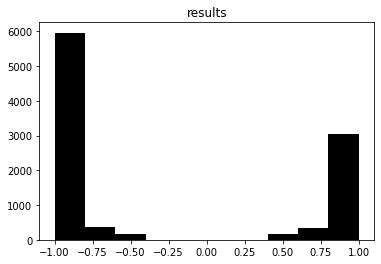

In [10]:
df.hist(column='results', grid=False, color='black')


In [11]:
df.tail(5000)

,Month,Date,Headline,Headline_Clean,cleaned_text,POS tagged,text,results
1859,June,2020-06-11,Seoul stocks end 9-day winning streak ahead of...,seoul stock end win streak ahead fed outlook w...,Seoul stocks end day winning streak ahead of ...,"[(Seoul, n), (stocks, n), (end, v), (day, n), ...",Seoul stock end day win streak ahead Fed out...,0.994089
3938,June,2020-06-11,Korea to reform real-name financial transactio...,korea reform financial transaction law,Korea to reform real name financial transactio...,"[(Korea, n), (reform, v), (real, a), (name, n)...",Korea reform real name financial transaction...,0.722038
3937,June,2020-06-11,Is jailed Anbang founder involved in US hotel ...,jail anbang founder involve us hotel fraud,Is jailed Anbang founder involved in US hotel ...,"[(jailed, v), (Anbang, n), (founder, n), (invo...",jail Anbang founder involve US hotel fraud,-0.995721
1858,June,2020-06-11,Finance minister warns against housing prices ...,finance minister warn house price amid counter...,Finance minister warns against housing prices ...,"[(Finance, n), (minister, n), (warns, n), (hou...",Finance minister warns housing price amid CO...,-0.970117
3935,June,2020-06-11,WHO's fumbled COVID-19 message,fumble message,WHO s fumbled COVID message,"[(fumbled, v), (COVID, n), (message, n)]",fumble COVID message,-0.994671
...,...,...,...,...,...,...,...,...
8916,December,2020-12-01,World's largest anti-corruption forum kicks off,world largest forum kick,World s largest anti corruption forum kicks off,"[(World, n), (largest, a), (anti, a), (corrupt...",World large anti corruption forum kick,-0.984928
8915,December,2020-12-01,Senior presidential aide stirs concern over at...,senior presidential aide stir concern attend f...,Senior presidential aide stirs concern over at...,"[(Senior, a), (presidential, a), (aide, n), (s...",Senior presidential aide stir concern attend...,0.946963
8914,December,2020-12-01,USITC set to delay ruling over LG-SK battery f...,usitc set delay rule battery feud,USITC set to delay ruling over LG SK battery f...,"[(USITC, n), (set, v), (delay, v), (ruling, n)...",USITC set delay ruling LG SK battery feud,-0.997425
8913,December,2020-12-01,"UAE, Korea marks 40th anniv. of diplomatic rel...",uae korea mark anniv diplomatic relations,UAE Korea marks th anniv of diplomatic rela...,"[(UAE, n), (Korea, n), (marks, n), (th, v), (a...",UAE Korea mark th anniv diplomatic relation,0.962705


# Check if all dates are in DF, add remaining dates to DF

In [15]:
#Check if all dates are in DF add remaining dates to DF
print(pd.date_range(start = '2020-03-01', end = '2020-09-30' ).difference(df.Date))
missing_dates = pd.date_range(start = '2020-03-01', end = '2020-09-30' ).difference(df.Date)
missing_dates_list = {'Date': missing_dates}

df = df.append(pd.DataFrame(missing_dates_list))

print(pd.date_range(start = '2020-03-01', end = '2020-09-30' ).difference(df.Date))


DatetimeIndex([], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


# Create DataFrame with average sentiment, frequency and mean per day and add day of the week variable

In [14]:
df_date_sentiment = df[['Date', 'results']]
df_date_sentiment.columns
print(df_date_sentiment.head())
variance = df_date_sentiment.groupby('Date', as_index=False)['results'].var()
print(variance)
count = df_date_sentiment.groupby('Date', as_index=False)['results'].count()
print(count)
df_date_sentiment = df_date_sentiment.groupby('Date', as_index=False)['results'].mean()
# mean = df_date_sentiment.groupby('Date', as_index=False)['results'].mean() 


merged_df = pd.merge(df_date_sentiment, variance, on="Date")
df_date_sentiment = pd.merge(merged_df, count, on="Date")
df_date_sentiment = df_date_sentiment.rename(columns={"results_x": "mean", "results_y": "variance", "results": "frequency"})

df_date_sentiment['Day of week'] = df_date_sentiment.Date.dt.dayofweek
df_date_sentiment.head(30)

           Date   results
6434 2020-02-12 -0.990079
6433 2020-02-12 -0.981442
6432 2020-02-12  0.746349
6431 2020-02-12 -0.999664
8270 2020-02-12  0.947006
          Date   results
0   2020-02-12  1.017103
1   2020-02-13  0.591204
2   2020-02-14  0.745597
3   2020-02-15  0.372629
4   2020-02-16  0.983921
..         ...       ...
289 2020-11-27  0.761044
290 2020-11-28  0.289553
291 2020-11-29  0.952241
292 2020-11-30  0.846598
293 2020-12-01  0.934852

[294 rows x 2 columns]
          Date  results
0   2020-02-12        6
1   2020-02-13       18
2   2020-02-14       21
3   2020-02-15       10
4   2020-02-16       12
..         ...      ...
289 2020-11-27       34
290 2020-11-28        9
291 2020-11-29       30
292 2020-11-30       47
293 2020-12-01       33

[294 rows x 2 columns]


,Date,mean,variance,frequency,Day of week
0,2020-02-12,-0.071590,1.017103,6,2
1,2020-02-13,-0.562234,0.591204,18,3
2,2020-02-14,-0.366171,0.745597,21,4
3,2020-02-15,-0.747131,0.372629,10,5
4,2020-02-16,0.022619,0.983921,12,6
5,2020-02-17,-0.405659,0.745392,20,0
6,2020-02-18,-0.288158,0.840806,22,1
7,2020-02-19,-0.713968,0.438740,22,2
8,2020-02-20,-0.616714,0.500210,39,3
9,2020-02-21,-0.638464,0.503959,43,4


In [9]:
df.results.value_counts()

-0.967562    20
-0.979950    12
-0.901946     6
-0.921116     6
-0.991910     6
             ..
-0.997818     1
-0.716601     1
 0.926966     1
 0.923181     1
 0.809761     1
Name: results, Length: 9815, dtype: int64

In [12]:
#Create DataFrame with average sentiment per day and add day of the week variable

df_date_sentiment = df[['Date', 'results']]
df_date_sentiment.Date = df_date_sentiment.Date.dt.date


df_date_sentiment = df_date_sentiment.groupby('Date', as_index=False)['results'].mean()
df_date_sentiment['Date'] = pd.to_datetime(df_date_sentiment['Date'])
df_date_sentiment['Day of week'] = df_date_sentiment.Date.dt.dayofweek



df_date_sentiment.head(30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Date,results,Day of week
0,2020-02-12,-0.071590,2
1,2020-02-13,-0.562234,3
2,2020-02-14,-0.366171,4
3,2020-02-15,-0.747131,5
4,2020-02-16,0.022619,6
5,2020-02-17,-0.405659,0
6,2020-02-18,-0.288158,1
7,2020-02-19,-0.713968,2
8,2020-02-20,-0.616714,3
9,2020-02-21,-0.638464,4


# Average the sentiment of Saturday and Sunday

In [16]:
#Average the sentiment of Saturday and Sunday
for i , row in df_date_sentiment.iterrows():
    if df_date_sentiment['Day of week'][i] == 5 and df_date_sentiment['Day of week'][i + 1] == 6:
        df_date_sentiment['frequency'][i+1] = (df_date_sentiment['frequency'][i] + df_date_sentiment['frequency'][i+1]) / 2
        df_date_sentiment['mean'][i+1] = (df_date_sentiment['mean'][i] + df_date_sentiment['mean'][i+1]) / 2
        df_date_sentiment['variance'][i+1] = (df_date_sentiment['variance'][i] + df_date_sentiment['variance'][i+1]) / 2
        print('YES!')
df_date_sentiment

YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!


<ipython-input-16-8b5778cda1c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_sentiment['frequency'][i+1] = (df_date_sentiment['frequency'][i] + df_date_sentiment['frequency'][i+1]) / 2
<ipython-input-16-8b5778cda1c2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_sentiment['mean'][i+1] = (df_date_sentiment['mean'][i] + df_date_sentiment['mean'][i+1]) / 2
<ipython-input-16-8b5778cda1c2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

,Date,mean,variance,frequency,Day of week
0,2020-02-12,-0.071590,1.017103,6,2
1,2020-02-13,-0.562234,0.591204,18,3
2,2020-02-14,-0.366171,0.745597,21,4
3,2020-02-15,-0.747131,0.372629,10,5
4,2020-02-16,-0.362256,0.678275,11,6
...,...,...,...,...,...
289,2020-11-27,-0.384914,0.761044,34,4
290,2020-11-28,-0.797719,0.289553,9,5
291,2020-11-29,-0.368319,0.620897,19,6
292,2020-11-30,-0.285910,0.846598,47,0


# Exclude Saturdays and make index of date

In [17]:
#Exclude Saturdays and make index of date
df_date_sentiment = df_date_sentiment.loc[df_date_sentiment['Day of week'] != 5]
df_date_sentiment = df_date_sentiment.set_index('Date')
print(len(df))
print(df.head(30))

10055
         Month       Date                                           Headline  \
6434  February 2020-02-12        China virus death toll reaches 1,110: govt.   
6433  February 2020-02-12  Number of S. Korea's virus cases unchanged at ...   
6432  February 2020-02-12                    Tracking down new mystery virus   
6431  February 2020-02-12  S. Korea's job indexes progress in Jan., likel...   
8270  February 2020-02-12      Third batch of Wuhan evacuees arrive in Korea   
6430  February 2020-02-12  N. Korea offers English, Chinese services for ...   
8269  February 2020-02-13                    China says it faces virus 'war'   
8268  February 2020-02-13  Coronavirus deaths in China pass 1,300 with sp...   
6429  February 2020-02-13  Coronavirus hits mobile carriers' launch cerem...   
6428  February 2020-02-13  No new coronavirus infections reported for 2nd...   
6427  February 2020-02-13  Tokyo Olympics boss blasts 'irresponsible rumo...   
6426  February 2020-02-13  S. Kore

# Import stock market index

In [18]:
import yfinance as yf

msft = yf.Ticker("^KS11")

# get stock info
print(msft.info)

# get historical market data
hist = msft.history(start='2020-02-17', end='2020-12-01')

{'exchange': 'KSC', 'shortName': 'KOSPI Composite Index', 'longName': 'KOSPI Composite Index', 'exchangeTimezoneName': 'Asia/Seoul', 'exchangeTimezoneShortName': 'KST', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '32400000', 'quoteType': 'INDEX', 'symbol': '^KS11', 'messageBoardId': 'finmb_INDEXKS11', 'market': 'kr_market', 'previousClose': 2963, 'regularMarketOpen': 2981.67, 'twoHundredDayAverage': 3120.2275, 'trailingAnnualDividendYield': None, 'payoutRatio': None, 'volume24Hr': None, 'regularMarketDayHigh': 2984.56, 'navPrice': None, 'averageDailyVolume10Day': 461290, 'totalAssets': None, 'regularMarketPreviousClose': 2963, 'fiftyDayAverage': 2980.057, 'trailingAnnualDividendRate': None, 'open': 2981.67, 'toCurrency': None, 'averageVolume10days': 461290, 'expireDate': None, 'yield': None, 'algorithm': None, 'dividendRate': None, 'exDividendDate': None, 'beta': None, 'circulatingSupply': None, 'startDate': None, 'regularMarketDayLow': 2955.9, 'priceHint': 2, 'currency': 'KRW', 

In [19]:
# Transform dates to DateTime
hist.index = pd.to_datetime(hist.index, unit = 'd')
hist['Day of week'] = hist.index.dayofweek



# Add Sunday dates and add the opening price of Monday to the Sunday 



In [20]:

dfnew = pd.DataFrame()
for i in range(len(hist)):
    if hist['Day of week'][i] == 4:
#         date = hist.index + datetime.timedelta(days=2) 
        dfnew = dfnew.append({'Date': hist.index[i], 'Close': hist.Close[i], 'Volume': hist.Volume[i], 'DOW': hist['Day of week'][i]}, ignore_index = True) 
        
        dfnew = dfnew.append({'Date': hist.index[i] + datetime.timedelta(days=2), 'Close': hist.Open[i+1], 'Volume': hist.Volume[i+1], 'DOW': 6}, ignore_index=True)
        
    
    
    else:
        dfnew = dfnew.append({'Date': hist.index[i], 'Close': hist.Close[i], 'Volume':hist.Volume[i], 'DOW': hist['Day of week'][i]}, ignore_index = True) 
       
    
dfnew = dfnew.set_index('Date')
dfnew





,Close,DOW,Volume
Date,,,
2020-02-17,2242.169922,0.0,458200.0
2020-02-18,2208.879883,1.0,470400.0
2020-02-19,2210.340088,2.0,590800.0
2020-02-20,2195.500000,3.0,709600.0
2020-02-21,2162.840088,4.0,635500.0
...,...,...,...
2020-11-25,2601.540039,2.0,1410100.0
2020-11-26,2625.909912,3.0,1387400.0
2020-11-27,2633.449951,4.0,1196000.0


# Create final DataFrame with variable Price Change

In [21]:
dfnew['Price Change'] = " "
for i in range(1, len(dfnew)-1):
    dfnew['Price Change'][i] = (dfnew['Close'][i]-dfnew['Close'][i-1]) / dfnew['Close'][i-1] * 100

dfnew = dfnew[1:-1]  
dfnew

<ipython-input-21-9269887c063d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnew['Price Change'][i] = (dfnew['Close'][i]-dfnew['Close'][i-1]) / dfnew['Close'][i-1] * 100


,Close,DOW,Volume,Price Change
Date,,,,
2020-02-18,2208.879883,1.0,470400.0,-1.484724
2020-02-19,2210.340088,2.0,590800.0,0.066106
2020-02-20,2195.500000,3.0,709600.0,-0.671394
2020-02-21,2162.840088,4.0,635500.0,-1.487584
2020-02-23,2114.040039,6.0,948600.0,-2.256295
...,...,...,...,...
2020-11-24,2617.760010,1.0,1364500.0,0.582878
2020-11-25,2601.540039,2.0,1410100.0,-0.619613
2020-11-26,2625.909912,3.0,1387400.0,0.936748


In [22]:
final_df = pd.concat([df_date_sentiment, dfnew], axis=1)
pd.set_option('display.max_rows', None)
final_df = final_df.dropna()
final_df

,mean,variance,frequency,Day of week,Close,DOW,Volume,Price Change
Date,,,,,,,,
2020-02-18,-0.288158,0.840806,22,1,2208.879883,1.0,470400.0,-1.484724
2020-02-19,-0.713968,0.438740,22,2,2210.340088,2.0,590800.0,0.066106
2020-02-20,-0.616714,0.500210,39,3,2195.500000,3.0,709600.0,-0.671394
2020-02-21,-0.638464,0.503959,43,4,2162.840088,4.0,635500.0,-1.487584
2020-02-23,-0.502857,0.721470,25,6,2114.040039,6.0,948600.0,-2.256295
2020-02-24,-0.542607,0.597412,53,0,2079.040039,0.0,948600.0,-1.655598
2020-02-25,-0.694258,0.403960,56,1,2103.610107,1.0,1565600.0,1.181799
2020-02-26,-0.602526,0.518608,48,2,2076.770020,2.0,810900.0,-1.275906
2020-02-27,-0.510988,0.634673,63,3,2054.889893,3.0,562500.0,-1.053565


In [23]:
# Import those libraries
import pandas as pd
from scipy.stats import pearsonr

# Convert dataframe into series
list1 = final_df['mean']
list2 = final_df['Price Change']

# Apply the pearsonr()
corr, _ = pearsonr(list1, list2)
print('Pearsons correlation: %.3f' % corr)



Pearsons correlation: 0.152


# OLS regression, no delay

In [24]:
Y = final_df['Price Change'].values.reshape(-1,1)
X = final_df['mean']
X = sm.add_constant(X)
model = sm.OLS(Y.astype(float),X.astype(float)).fit()
# model = sm.OLS(Y.astype(float),final_df['mean'].astype(float)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5.495
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0199
Time:                        12:54:31   Log-Likelihood:                -459.75
No. Observations:                 233   AIC:                             923.5
Df Residuals:                     231   BIC:                             930.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4494      0.192      2.336      0.0

In [49]:
final_df['7day_rolling_avg'] = final_df['mean'].rolling(7).mean()

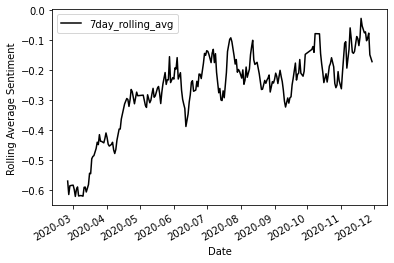

In [53]:
# plot_price_change = final_df.plot(use_index=True, y=['Close'], color='black')
# plot_sentiment = final_df.plot(use_index=True, y=['mean'], color='black')
plot_rolling_avg_sentiment = final_df.plot(use_index=True, y=['7day_rolling_avg'], color='black')
# ax.set_ylim(-5,5)
plt.xlabel('Date')
plt.ylabel('Rolling Average Sentiment')
plt.show()

# ADF Statistic

In [46]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
series = final_df
X = final_df['Price Change']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.863655
p-value: 0.000041
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574


# Granger Causality

In [26]:
final_df['mean_dif'] = final_df['mean']-final_df['mean'].shift(1)

In [32]:
var_df = final_df[['Price Change', 'mean_dif']]
var_df['Price Change'] = var_df['Price Change'].astype(float)
var_df['mean_dif'] = var_df['mean_dif'].astype(float)
var_df = var_df[1:]

<ipython-input-32-cb83c7e58fda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_df['Price Change'] = var_df['Price Change'].astype(float)
<ipython-input-32-cb83c7e58fda>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_df['mean_dif'] = var_df['mean_dif'].astype(float)


In [33]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [35]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(var_df[['Price Change', 'mean_dif']], maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6190  , p=0.1070  , df_denom=226, df_num=1
ssr based chi2 test:   chi2=2.6538  , p=0.1033  , df=1
likelihood ratio test: chi2=2.6385  , p=0.1043  , df=1
parameter F test:         F=2.6190  , p=0.1070  , df_denom=226, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1236  , p=0.1220  , df_denom=223, df_num=2
ssr based chi2 test:   chi2=4.3425  , p=0.1140  , df=2
likelihood ratio test: chi2=4.3016  , p=0.1164  , df=2
parameter F test:         F=2.1236  , p=0.1220  , df_denom=223, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8918  , p=0.1318  , df_denom=220, df_num=3
ssr based chi2 test:   chi2=5.8561  , p=0.1188  , df=3
likelihood ratio test: chi2=5.7818  , p=0.1227  , df=3
parameter F test:         F=1.8918  , p=0.1318  , df_denom=220, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3882  , p=0.2390  

{1: ({'ssr_ftest': (2.6189920220273653, 0.10698622710718601, 226.0, 1),
   'ssr_chi2test': (2.6537574028507374, 0.10330545577127072, 1),
   'lrtest': (2.638498691898576, 0.10430206609115016, 1),
   'params_ftest': (2.6189920220273595, 0.10698622710718601, 226.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.123611715434747, 0.12201126667134601, 223.0, 2),
   'ssr_chi2test': (4.342452655776881, 0.1140376835346208, 2),
   'lrtest': (4.301617494479615, 0.11638998961666754, 2),
   'params_ftest': (2.123611715434754, 0.12201126667134601, 223.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.8918421844653561, 0.13184926376063164, 220.0, 3),
   'ssr_chi2test': (5.856111489185944, 0.11882446811336876, 3),
   'lrtest': (5.781848461149707, 0.12271981681652196, 3),
   'params_ftest': (1.8918421844653703, 0.13184926376062994, 220.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 